In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
import seaborn as sns 

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
df = pd.read_csv(r"C:\Users\mishr\Downloads\diabetes_prediction_dataset.csv")

In [3]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [5]:
df.corr(numeric_only=True)



,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.251171,0.233354,0.337396,0.101354,0.110672,0.258008
hypertension,0.251171,1.000000,0.121262,0.147666,0.080939,0.084429,0.197823
heart_disease,0.233354,0.121262,1.000000,0.061198,0.067589,0.070066,0.171727
bmi,0.337396,0.147666,0.061198,1.000000,0.082997,0.091261,0.214357
HbA1c_level,0.101354,0.080939,0.067589,0.082997,1.000000,0.166733,0.400660
blood_glucose_level,0.110672,0.084429,0.070066,0.091261,0.166733,1.000000,0.419558
diabetes,0.258008,0.197823,0.171727,0.214357,0.400660,0.419558,1.000000


In [6]:
for column in df.columns:
    unique_values = df[column].unique()

    print('Column "{}" has unique values: {}'.format(column,unique_values))

Column "gender" has unique values: ['Female' 'Male' 'Other']
Column "age" has unique values: [80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48]
Column "hypertension" has unique values: [0 1]
Column "heart_disease" has unique values: [1 0]
Column "smoking_history" has unique values: ['never' 'No Info' 'current' 'former' 'ever' 'not current']
Column "bmi" has unique values: [25.19 27.32 23.45 ... 59.42 44.39 60.52]
Column "HbA1c_level" h

In [7]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [8]:
df['smoking_history'].value_counts()/len(df)

smoking_history
No Info        0.35816
never          0.35095
former         0.09352
current        0.09286
not current    0.06447
ever           0.04004
Name: count, dtype: float64

In [9]:
df['smoking_history'] = df['smoking_history'].replace('No Info ',pd.NA)

In [10]:
mode_value = df['smoking_history'].mode()[0]

In [11]:
df['smoking_history'] = df['smoking_history'].fillna(mode_value)

In [12]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [14]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [15]:
df['bmi'] = [float(str(i).replace(",","")) for i in df['bmi']]

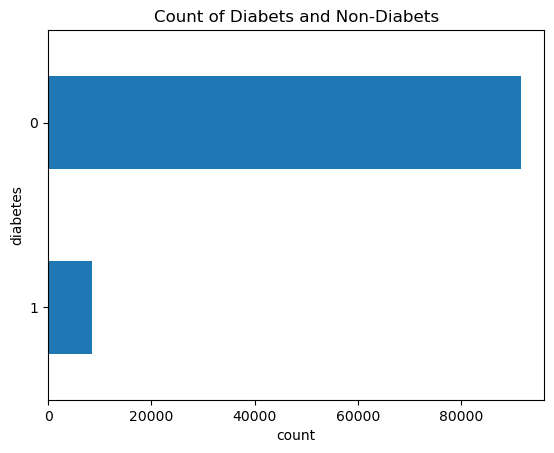

In [16]:
df['diabetes'].value_counts().plot(kind='barh')
plt.xlabel('count')
plt.ylabel('diabetes')
plt.title('Count of Diabets and Non-Diabets')
plt.gca().invert_yaxis()
plt.show()

In [17]:
df['diabetes'].value_counts()/len(df)*100

diabetes
0    91.5
1     8.5
Name: count, dtype: float64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [19]:
le = LabelEncoder()
le

LabelEncoder()

In [20]:
Label_encod_columns =['gender','smoking_history'] 
df[Label_encod_columns] = df[Label_encod_columns].apply(le.fit_transform)

In [21]:
df.head(3)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0


<Axes: >

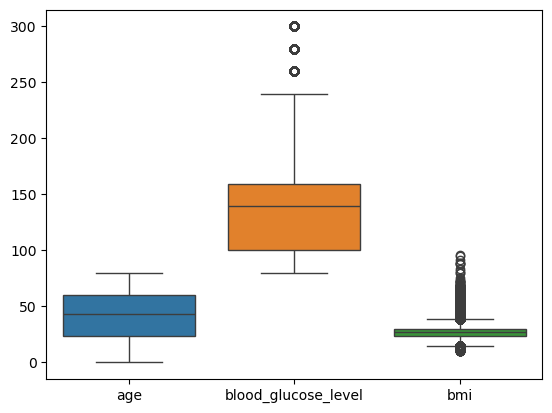

In [22]:
sns.boxplot(data=df[['age','blood_glucose_level','bmi']])

<Axes: >

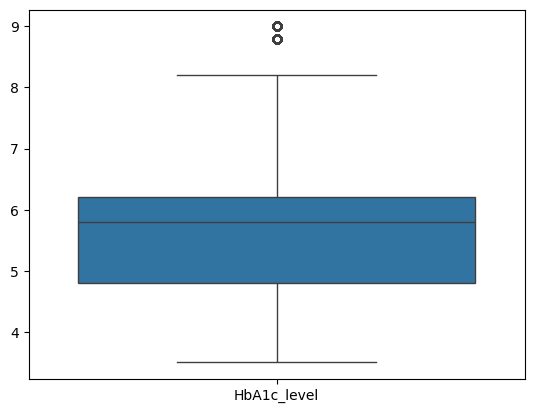

In [23]:
sns.boxplot(data=df[['HbA1c_level']])

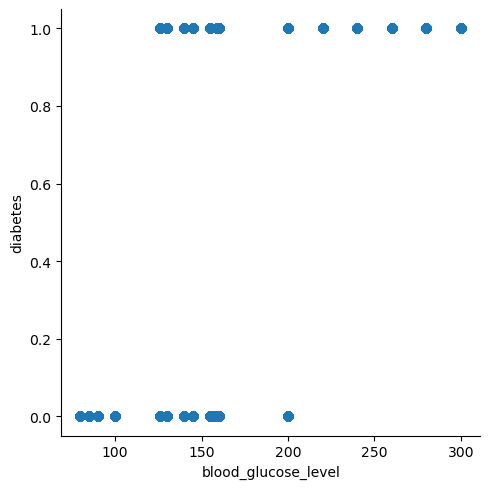

In [24]:
sns.lmplot(data=df,x='blood_glucose_level',y='diabetes',fit_reg=False);

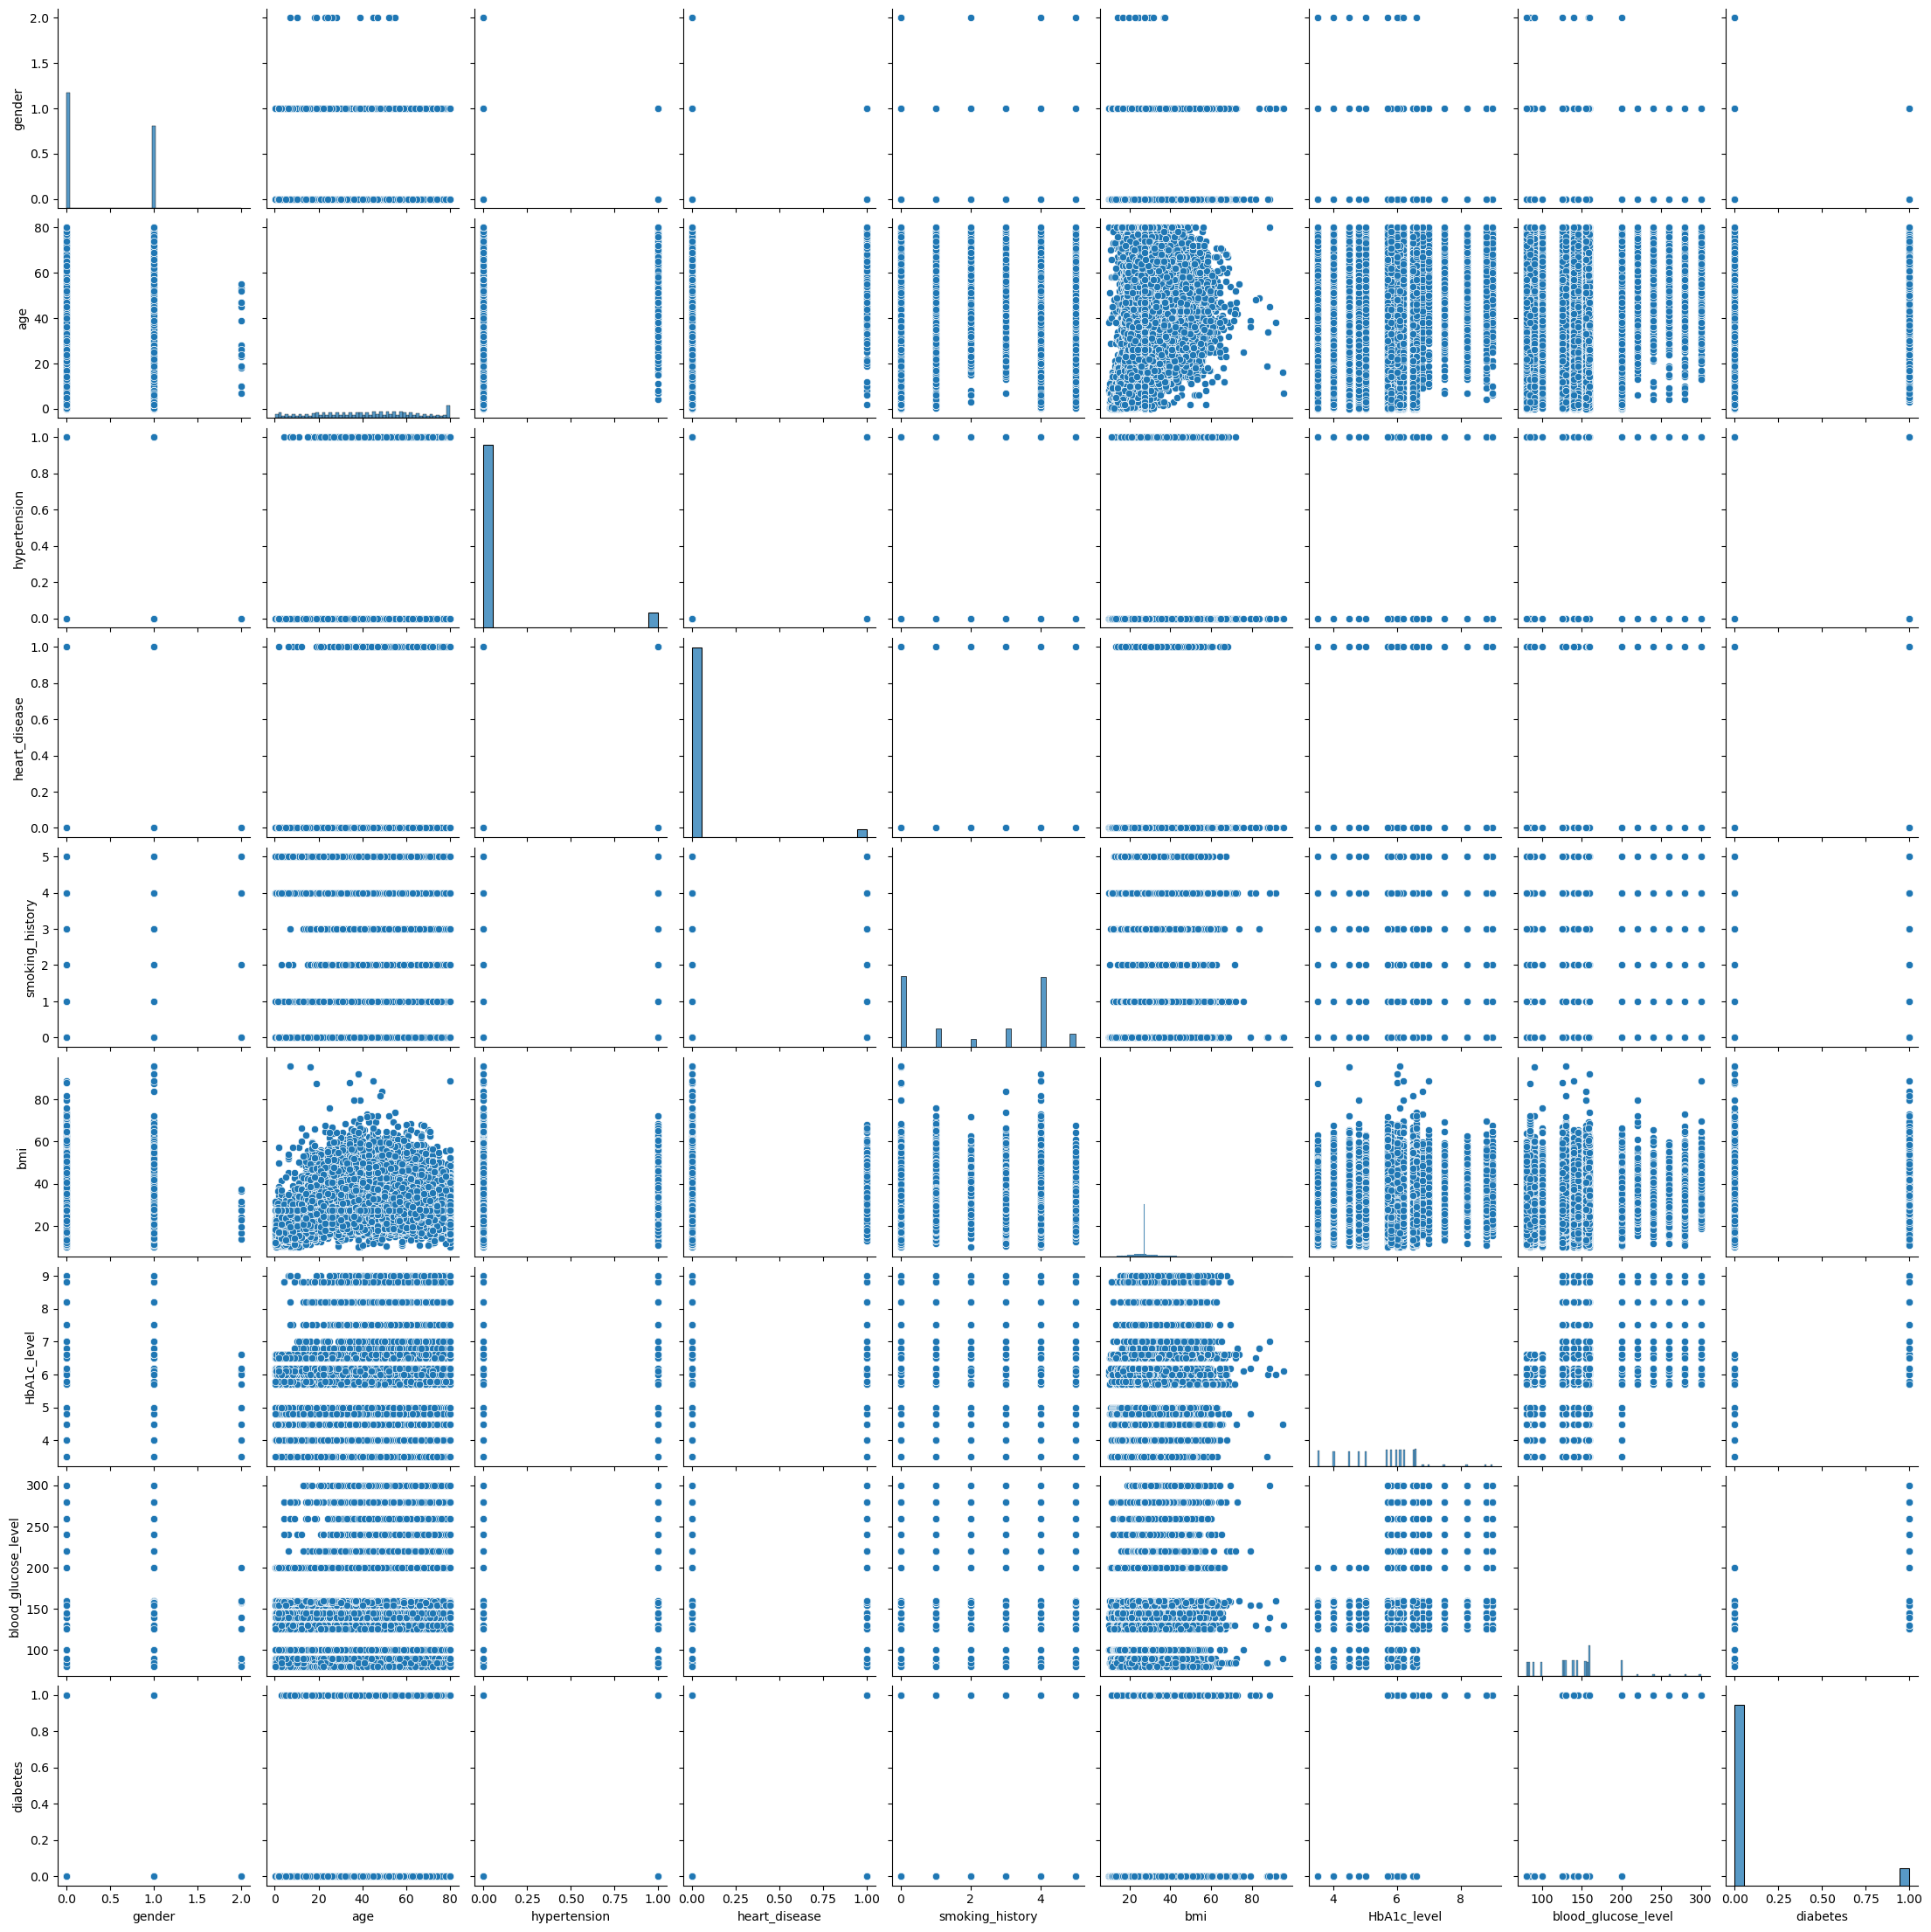

In [25]:
sns.pairplot(df);

In [26]:
df.corr()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
gender,1.000000,-0.030656,0.014203,0.077696,-0.077919,-0.022994,0.019957,0.017199,0.037411
age,-0.030656,1.000000,0.251171,0.233354,0.228608,0.337396,0.101354,0.110672,0.258008
hypertension,0.014203,0.251171,1.000000,0.121262,0.093177,0.147666,0.080939,0.084429,0.197823
heart_disease,0.077696,0.233354,0.121262,1.000000,0.027598,0.061198,0.067589,0.070066,0.171727
smoking_history,-0.077919,0.228608,0.093177,0.027598,1.000000,0.179361,0.037369,0.040219,0.094290
bmi,-0.022994,0.337396,0.147666,0.061198,0.179361,1.000000,0.082997,0.091261,0.214357
HbA1c_level,0.019957,0.101354,0.080939,0.067589,0.037369,0.082997,1.000000,0.166733,0.400660
blood_glucose_level,0.017199,0.110672,0.084429,0.070066,0.040219,0.091261,0.166733,1.000000,0.419558
diabetes,0.037411,0.258008,0.197823,0.171727,0.094290,0.214357,0.400660,0.419558,1.000000


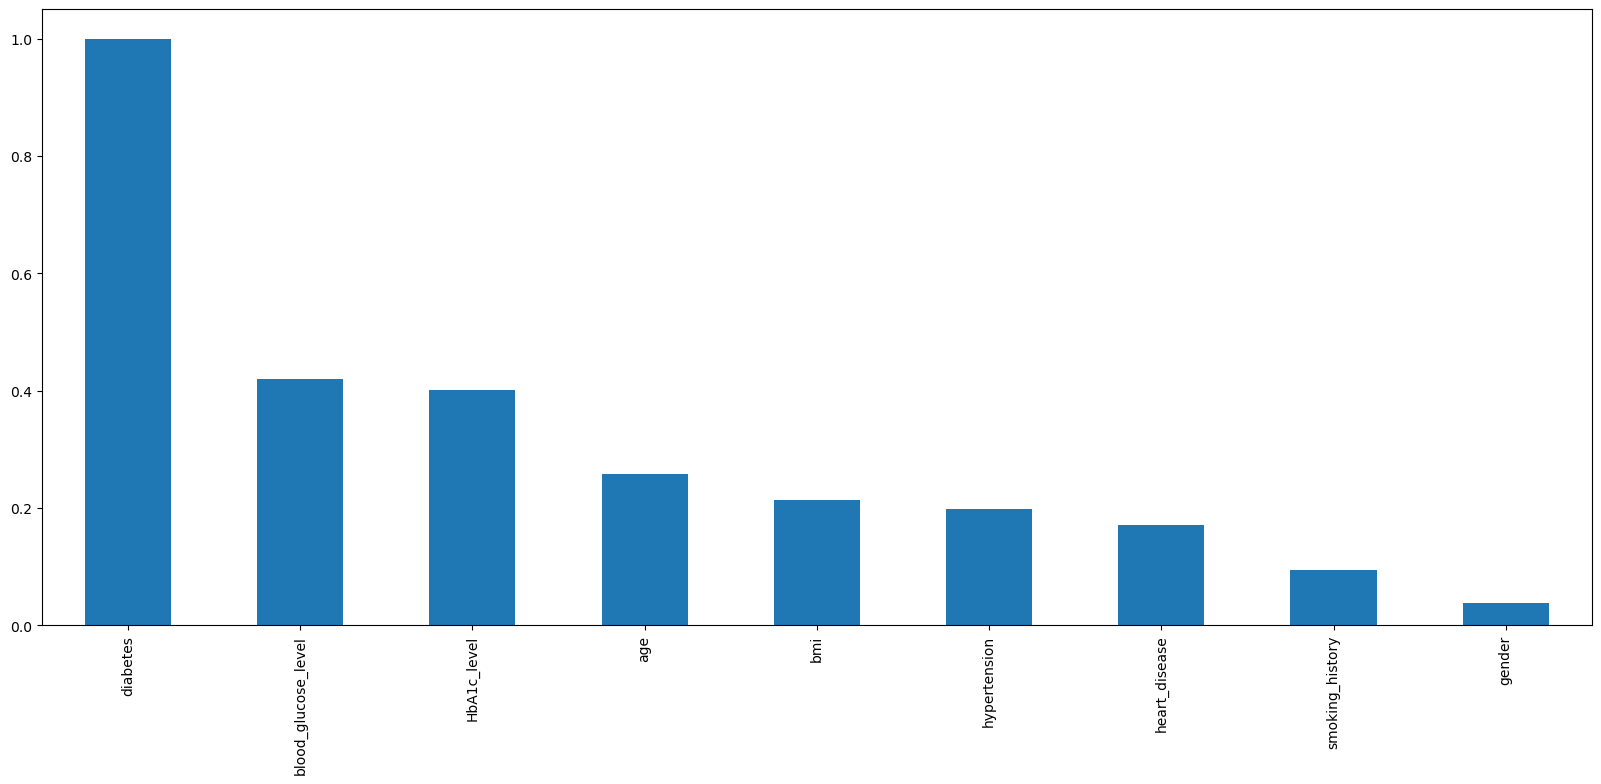

In [27]:
plt.figure(figsize=(20,8))

df.corr()['diabetes'].sort_values(ascending=False).plot(kind='bar');

In [28]:
x = df.loc[:,'age':'heart_disease'].join(df.loc[:,'bmi':'blood_glucose_level'])
x

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,80.0,0,1,25.19,6.6,140
1,54.0,0,0,27.32,6.6,80
2,28.0,0,0,27.32,5.7,158
3,36.0,0,0,23.45,5.0,155
4,76.0,1,1,20.14,4.8,155
...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90
99996,2.0,0,0,17.37,6.5,100
99997,66.0,0,0,27.83,5.7,155
99998,24.0,0,0,35.42,4.0,100


In [29]:
y = df.iloc[:,-1]
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: diabetes, Length: 100000, dtype: int64

In [30]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size = 0.20 , random_state = 0)

In [31]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [32]:
lr = LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression()

In [33]:
y_pred = lr.predict(x_test)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [34]:
y_test[:10]

3582     0
60498    0
53227    0
21333    0
3885     0
51521    0
84261    0
10685    1
59948    0
41032    0
Name: diabetes, dtype: int64

In [35]:
cm = confusion_matrix(y_pred,y_test)
cm

array([[18114,   621],
       [  183,  1082]], dtype=int64)

<Axes: >

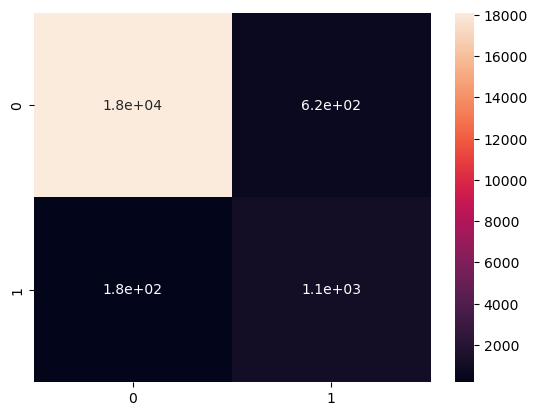

In [36]:
sns.heatmap(cm,annot=True)

In [37]:
accuracy_score(y_pred,y_test)*100

95.98

In [38]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18735
           1       0.64      0.86      0.73      1265

    accuracy                           0.96     20000
   macro avg       0.81      0.91      0.85     20000
weighted avg       0.97      0.96      0.96     20000



In [39]:
y_train.value_counts()

diabetes
0    73203
1     6797
Name: count, dtype: int64

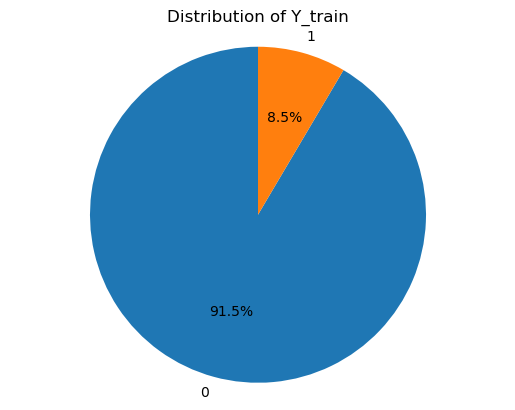

In [40]:
value_counts = y_train.value_counts()
plt.pie(value_counts , labels=  value_counts.index , autopct='%1.1f%%',startangle=90)
plt.title('Distribution of Y_train')
plt.axis('equal')
plt.show()

In [41]:
smote = SMOTE()

x_os , y_os = smote.fit_resample(x,y)


In [42]:
y_os.value_counts()

diabetes
0    91500
1    91500
Name: count, dtype: int64

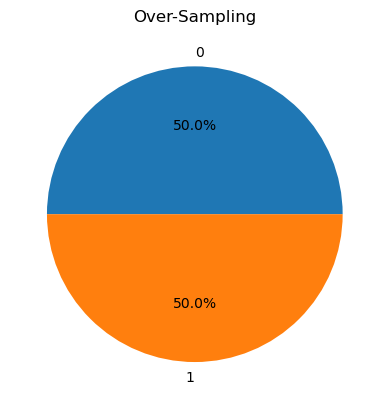

In [43]:
plt.pie(y_os.value_counts() , labels = y_os.value_counts().index , autopct='%1.1f%%')
plt.title('Over-Sampling')
plt.show()

In [44]:
x_train1 , x_test1 , y_train1 , y_test1 = train_test_split(x_os, y_os , test_size=0.20 , random_state=0)

In [45]:
x_train1 = sc.fit_transform(x_train1)
x_test1 = sc.transform(x_test1)

In [46]:
x_train1_scaled = pd.DataFrame(x_train1)
print(x_train1_scaled.shape)
print(y_train1.shape)

(146400, 6)
(146400,)


In [47]:
x_test1_scaled = pd.DataFrame(x_test1)
print(x_test1_scaled.shape)
print(y_test1.shape)

(36600, 6)
(36600,)


In [48]:
model_lr = LogisticRegression()
model_lr.fit(x_train1_scaled , y_train1)

LogisticRegression()

In [49]:
y_pred_model = model_lr.predict(x_test1_scaled)
y_pred_model[:10]

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0], dtype=int64)

In [50]:
y_test1[:10]

53326     0
32582     0
42963     0
130043    1
93597     0
107421    1
64577     0
15270     0
55481     0
79433     0
Name: diabetes, dtype: int64

In [51]:
print(classification_report(y_pred_model,y_test1))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     18150
           1       0.89      0.89      0.89     18450

    accuracy                           0.89     36600
   macro avg       0.89      0.89      0.89     36600
weighted avg       0.89      0.89      0.89     36600



In [52]:
cm1 = confusion_matrix(y_pred_model,y_test1)
cm1

array([[16093,  2057],
       [ 2099, 16351]], dtype=int64)

<Axes: >

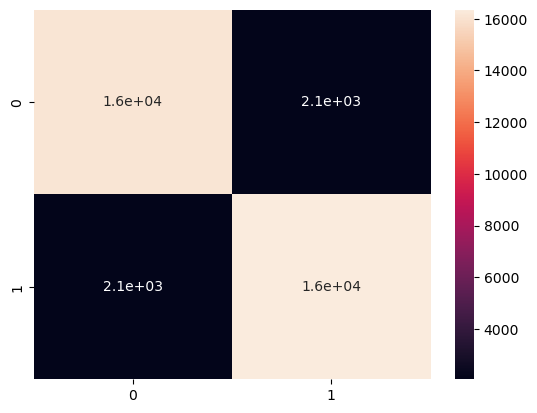

In [53]:
sns.heatmap(cm1,annot=True)

In [54]:
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train1_scaled , y_train1)


DecisionTreeClassifier()

In [55]:
y_pred_model1 = model_dt.predict(x_test1_scaled)
y_pred_model1[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [56]:
y_test1[:10]

53326     0
32582     0
42963     0
130043    1
93597     0
107421    1
64577     0
15270     0
55481     0
79433     0
Name: diabetes, dtype: int64

In [57]:
print(classification_report(y_pred_model1,y_test1))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18123
           1       0.98      0.97      0.97     18477

    accuracy                           0.97     36600
   macro avg       0.97      0.97      0.97     36600
weighted avg       0.97      0.97      0.97     36600



In [58]:
cm2 = confusion_matrix(y_pred_model1,y_test1)
cm2

array([[17667,   456],
       [  525, 17952]], dtype=int64)

<Axes: >

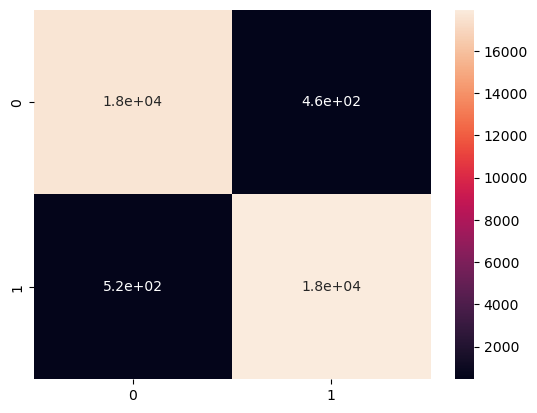

In [59]:
sns.heatmap(cm2,annot=True)

In [60]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train1_scaled , y_train1)

RandomForestClassifier()

In [61]:
y_pred_model2 = model_rf.predict(x_test1_scaled)
y_pred_model2[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [62]:
y_test1[:10]

53326     0
32582     0
42963     0
130043    1
93597     0
107421    1
64577     0
15270     0
55481     0
79433     0
Name: diabetes, dtype: int64

In [63]:
print(classification_report(y_pred_model2,y_test1))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18244
           1       0.98      0.98      0.98     18356

    accuracy                           0.98     36600
   macro avg       0.98      0.98      0.98     36600
weighted avg       0.98      0.98      0.98     36600



In [64]:
cm3 = confusion_matrix(y_pred_model2,y_test1)
cm3

array([[17801,   443],
       [  391, 17965]], dtype=int64)

In [65]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train1_scaled , y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [66]:
y_pred_model3 = model_xgb.predict(x_test1_scaled)
y_pred_model3[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [67]:
print(classification_report(y_pred_model3,y_test1))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18853
           1       0.95      0.99      0.97     17747

    accuracy                           0.97     36600
   macro avg       0.97      0.97      0.97     36600
weighted avg       0.97      0.97      0.97     36600



In [68]:
cm4 = confusion_matrix(y_pred_model2,y_test1)
cm4

array([[17801,   443],
       [  391, 17965]], dtype=int64)

In [69]:
model_lgbm = lgb.LGBMClassifier()
model_lgbm.fit(x_train1_scaled , y_train1)

[LightGBM] [Info] Number of positive: 73092, number of negative: 73308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 146400, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499262 -> initscore=-0.002951
[LightGBM] [Info] Start training from score -0.002951


LGBMClassifier()

In [70]:
y_pred_model4 = model_lgbm.predict(x_test1_scaled)
y_pred_model4[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [71]:
y_pred_model4 = model_lgbm.predict(x_test1_scaled)
y_pred_model4[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [72]:
print(classification_report(y_pred_model4,y_test1))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18895
           1       0.95      0.99      0.97     17705

    accuracy                           0.97     36600
   macro avg       0.97      0.97      0.97     36600
weighted avg       0.97      0.97      0.97     36600



In [78]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', None],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestClassifier(random_state=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='accuracy')

# Fit the grid search to your data (X_train, y_train)
grid_search.fit(x_train1_scaled, y_train1)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)


Best parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': None, 'n_estimators': 200}


# Final Model


In [83]:
final_model = RandomForestClassifier(random_state=0, bootstrap = True, max_depth = 30, max_features = None, n_estimators = 200)
final_model.fit(x_train1_scaled, y_train1)

RandomForestClassifier(max_depth=30, max_features=None, n_estimators=200,
                       random_state=0)

In [85]:
y_pred_final_model = final_model.predict(x_test1_scaled)
y_pred_final_model[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [87]:
print(classification_report(y_pred_final_model,y_test1))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     18365
           1       0.98      0.99      0.98     18235

    accuracy                           0.98     36600
   macro avg       0.98      0.98      0.98     36600
weighted avg       0.98      0.98      0.98     36600



In [89]:
cm_final_model = confusion_matrix(y_pred_final_model,y_test1)
cm_final_model

array([[17925,   440],
       [  267, 17968]], dtype=int64)

In [91]:
import pickle

# Save the final model to a pickle file
with open('final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [93]:
# Load the model from the pickle file
with open('final_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Define the mean and standard deviation of the training data
mean_values = [41.885856, 0.07485, 0.03942, 27.320767, 5.527507, 138.058060]
std_values = [22.516840, 0.26315, 0.194593, 6.636783, 1.070672, 40.708136]

# Define the input features for prediction
age = 30
hypertension = 0
heart_disease = 0
bmi = 100.0
HbA1c_level = 5.0
blood_glucose_level = 90

# Scale the input features manually
scaled_features = [(x - mean) / std for x, mean, std in zip(
    [age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_level],
    mean_values, std_values
)]

# Make predictions on the scaled data
prediction = loaded_model.predict([scaled_features])

# Print the prediction
if prediction[0] == 1:
    print("Diabetic")
else:
    print("Not Diabetic")


Not Diabetic
